In [1]:
!pip install gym
!pip install torch
!pip install torchvision

You should consider upgrading via the 'c:\users\mi\anaconda3\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\mi\anaconda3\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\mi\anaconda3\python.exe -m pip install --upgrade pip' command.


In [1]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import copy

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

In [3]:
torch.cuda.is_available()

True

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
device

device(type='cuda', index=0)

In [6]:
Transition = namedtuple('Transition', 'state action reward next_state done')

In [38]:
class Cache:
    def __init__(self, capacity):
        self.capacity = capacity
        self.states = torch.zeros((capacity, 2)).float().to(device)
        self.next_states = torch.zeros((capacity, 2)).float().to(device)
        self.actions = torch.zeros(capacity).long().to(device)
        self.rewards = torch.zeros(capacity).to(device)
        self.dones = torch.zeros(capacity).bool().to(device)
        
        self.index = 0
        self._full = False
        
    
    def push(self, state, next_state, action, reward, done):
        self.states[self.index] = state
        self.next_states[self.index] = next_state
        self.rewards[self.index] = reward
        self.dones[self.index] = done
        self.actions[self.index] = action
        
        self.index = self.index + 1
        if self.index == self.capacity:
            self.index %= self.capacity
            self._full = True
    
    def sample(self, batch_size):
        indexes = torch.randperm(self.capacity)[:batch_size]
        return self.states[indexes], self.next_states[indexes] \
                , self.actions[indexes], self.rewards[indexes], self.dones[indexes]
    
    
    def full(self):
        return self._full
    
Cache(5).sample(2)

(tensor([[0., 0.],
         [0., 0.]], device='cuda:0'), tensor([[0., 0.],
         [0., 0.]], device='cuda:0'), tensor([0, 0], device='cuda:0'), tensor([0., 0.], device='cuda:0'), tensor([False, False], device='cuda:0'))

In [60]:
class Agent:
    def __init__(self, net, output_dim, lr, optimizer, loss_function
                 , gamma, eps, eps_min_bound, cache_size, batch_size, iterations):
        
        self.policy_net = net
        self.target_net = copy.deepcopy(self.policy_net)
        
        self.policy_net.to(device)
        self.target_net.to(device)
        
        self.optimizer = optimizer(self.policy_net.parameters(), lr=lr)
        self.loss_function = loss_function
        
        self.output_dim = output_dim
        
        self.gamma = gamma
        self.eps = eps
        self.eps_decay = (eps - eps_min_bound) / iterations
        self.eps_min_bound = eps_min_bound
        
        self.cache = Cache(cache_size)
        self.batch_size = batch_size
        
        self.iterations = iterations
    
    def select_action(self, state):
        self.eps -= self.eps_decay
        self.eps = max(self.eps, self.eps_min_bound)
        
        if random.random() < self.eps:
            return random.randint(0, self.output_dim - 1)
        return self.policy_net(state).argmax().item()
    
    
    def fit(self):
        states, next_states, actions, rewards, dones = self.cache.sample(self.batch_size)
        
        target_q = torch.zeros(self.batch_size).to(device).float()
        with torch.no_grad():
            target_q = self.target_net(next_states).max(1)[0]
        target_q[done] = 0
        target_q = rewards + target_q * self.gamma
        
        actual_q = self.policy_net(states).gather(1, actions.unsqueeze(1))
        
        loss = self.loss_function(actual_q, target_q.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [61]:
env = gym.make('MountainCar-v0')

In [62]:
net = nn.Sequential(
        nn.Linear(2, 16),
        nn.ReLU(),
        nn.Linear(16, 16),
        nn.ReLU(),
        nn.Linear(16, 3)
    )
agent = Agent(net, 3, 0.00003, optim.Adam, F.smooth_l1_loss, 0.99, 0.9, 0.1, 5000, 100, 100_000)

In [65]:
%%time

done = True
steps = 0
total_reward = (0, 0)
reward_records = []

for i in range(agent.iterations):
    steps += 1
    if done:
        reward_records.append(total_reward)
        steps = 0
        total_reward = (0, 0)
        state = torch.tensor(env.reset()).to(device).float()
    if i % (agent.iterations // 5) == 0:
        print(f'{i} of {agent.iterations}')

    action = agent.select_action(state)

    next_state, reward, done, _ = env.step(action)
    reward = (reward, np.abs(next_state[1]))
    total_reward = (total_reward[0] + reward[0], total_reward[1] + reward[1])
    next_state = torch.tensor(next_state).float().to(device)

    agent.cache.push(state=state, next_state=next_state, action=action, reward=reward[1], done=done)
    state = next_state

    if agent.cache.full():
        agent.fit()

    if i % 2000 == 0:
        agent.target_net = agent.policy_net

0 of 100000
20000 of 100000
40000 of 100000
60000 of 100000
80000 of 100000
Wall time: 4min 59s


In [69]:
try:
    n_games = 1
    for i in range(n_games):
        done = False
        state = torch.tensor(env.reset()).to(device).float()
        while not done:
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)

            next_state = torch.tensor(next_state).float().to(device)

            state = next_state

            env.render()
finally:
    env.close()

In [52]:
env.close()

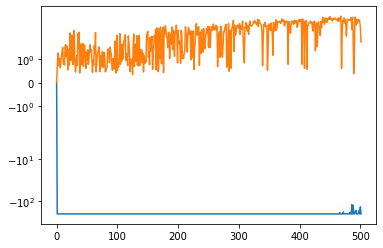

In [82]:
x = list(zip(*reward_records))
plt.yscale('symlog')
plt.plot(range(len(reward_records)), x[0])
plt.plot(range(len(reward_records)), x[1])
plt.show()

In [2]:
env = gym.make('Breakout-v0') 

OSError: [WinError 126] Не найден указанный модуль

In [ ]:
env.render()

In [ ]:
env.close()

In [83]:
net = nn.Sequential(
        nn.Linear(2, 16),
        nn.ReLU(),
        nn.Linear(16, 16),
        nn.ReLU(),
        nn.Linear(16, 3)
    )
agent = Agent(net, 3, 0.00003, optim.Adam, F.smooth_l1_loss, 0.99, 0.9, 0.1, 5000, 100, 100_000)

In [ ]:
!pip install git+https://github.com/Kojoley/atari-py.git